In [9]:
import json
import sys
import glob
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [10]:
DIR = "/Users/maggicl/Git/bachelorThesis/figure_7/"

In [11]:
def tier(p):
    if p <= 99:
        return "Free"
    elif p <= 115:
        return "Best effort"
    elif p <= 119:
        return "Mid"
    elif p <= 359:
        return "Production"
    else:
        return "Monitoring"

def categorical_plot(df, key, title, sorted_xs = None):    
    if sorted_xs == None:
        xs = set()
        lines = []
        for t in [4,5,6,7]:
            xs = xs.union(np.array(df[df["term"] == t][key]).reshape(-1))
        xs = [str(x) for x in sorted(xs)]
    else:
        xs = sorted_xs
        
    plt.figure(figsize=(4,3))
    ax = plt.gca()
    lines = []
    for t in [4,5,6,7]:
        ys = []
        if xs[0] == "-1":
            del xs[0]
        for x in xs:
            partsum = df[(df["term"] != -1) & (df[key] == x)]["count"].sum().astype(int)
            y = df[(df["term"] == t) & (df[key] == x)]["count"]
            ys.append(100 * ((y.values.astype(int)[0] / partsum if partsum > 0 else y.values.astype(int)[0]) if y.any()
                             else 0))
        lines.append(ax.plot(xs,ys, marker='.')[0])

    if key == "tier":
        plt.xlabel("Tier")
    elif key == "exectime":
        plt.xlabel("Execution time")
    else:
        plt.xlabel("Machine concurrency")
    
    plt.ylabel("Event rate [%]")
    plt.xticks(xs)
    lgd = plt.legend(lines, ["EVICT", "FAIL", "FINISH", "KILL"], loc="best",
              bbox_to_anchor=(1,1))
    plt.title(title) 
    plt.savefig('../report/figures/figure_7/%s-%s.pgf' % 
                (key.replace("_", ""), cluster), bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

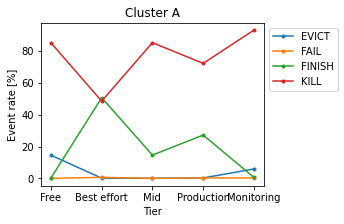

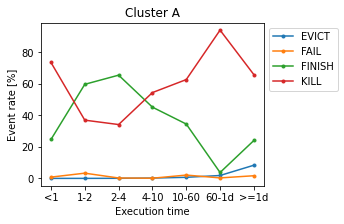

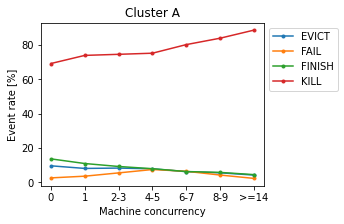

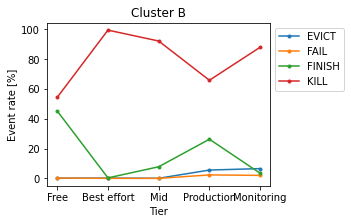

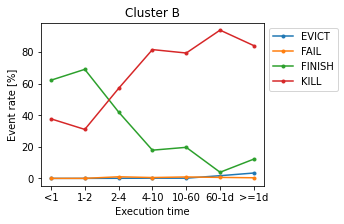

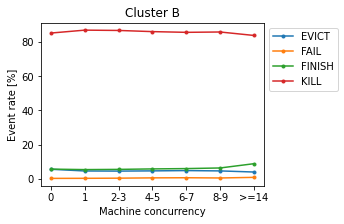

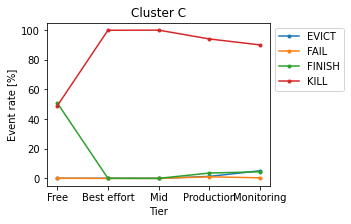

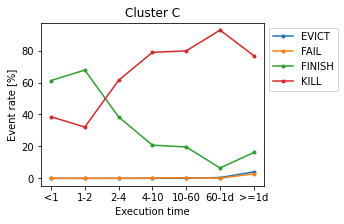

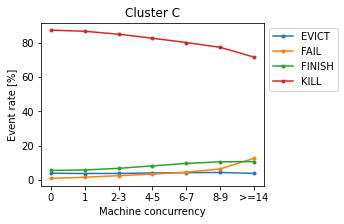

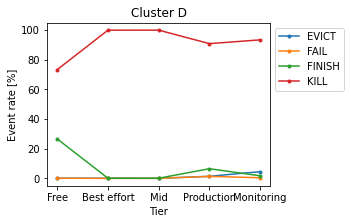

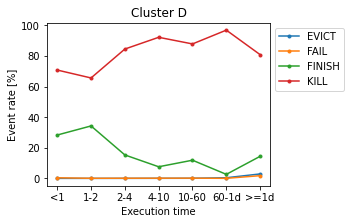

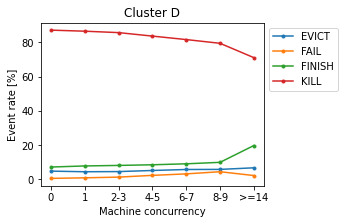

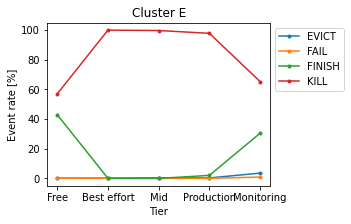

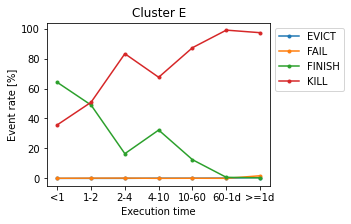

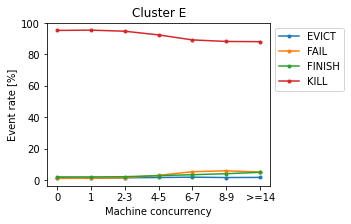

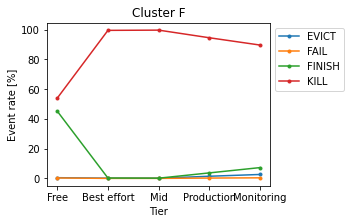

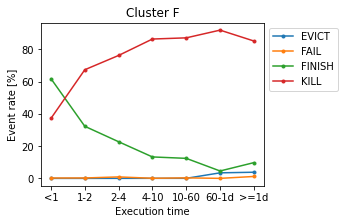

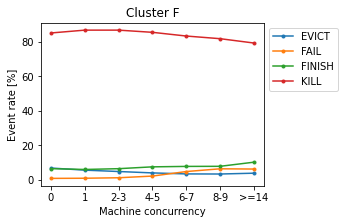

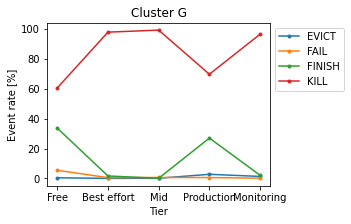

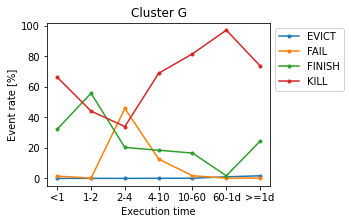

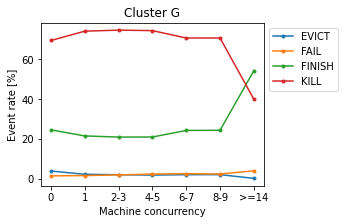

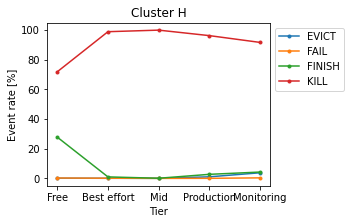

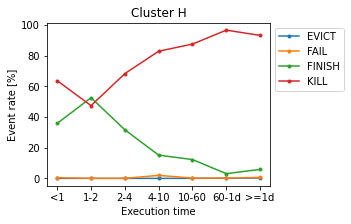

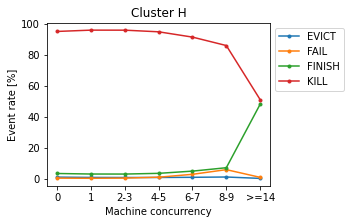

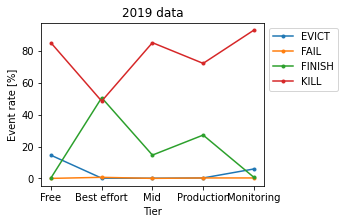

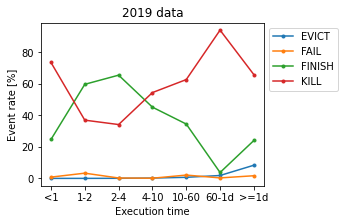

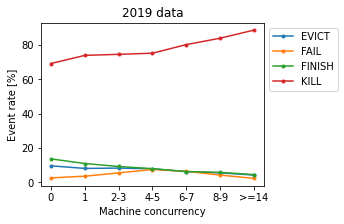

    term priority  count
0      4      0-1     18
1      4      2-4     38
2      4      5-8     20
3      4     9-11     28
4      5      0-1      0
5      5      2-4      4
6      5      5-8     21
7      5     9-11     78
8      6      0-1      0
9      6      2-4      7
10     6      5-8     25
11     6     9-11     65
12     7      0-1      0
13     7      2-4      4
14     7      5-8     17
15     7     9-11     90


In [15]:
dfatot = None
dfbtot = None
dfctot = None

for cluster in "abcdefgh":
    # Processing figure 7a
    
    dfa = pd.read_csv(glob.glob(DIR + cluster + "_priority/part-*")[0], header=None,
                    names=["term", "priority", "count"])
    dfa["tier"] = dfa["priority"].apply(tier)
    dfa = dfa[dfa["priority"].ge(0)]
    dfa = dfa.groupby(["tier", "term"]).sum().reset_index()
    dfa = dfa[dfa["term"].isin(range(4,8))]
    del dfa["priority"]
    if dfatot is None:
        dfatot = dfa
    else:
        dfatot.append(dfa)
    
    xs = ["Free", "Best effort", "Mid", "Production", "Monitoring"]
    categorical_plot(dfa, "tier", "Cluster " + cluster.upper(), xs)
    
    # Processing figure 7b
    
    dfb = pd.read_csv(glob.glob(DIR + cluster + "_exectime/part-*")[0], header=None,
                names=["term", "ignore", "exectime", "count"])
    del dfb["ignore"]
    dfb = dfb.sort_values(["term", "exectime"])
    if dfbtot is None:
        dfbtot = dfb
    else:
        dfbtot.append(dfb)
    
    xs = ["<1", "1-2", "2-4", "4-10", "10-60", "60-1d", ">=1d"]
    categorical_plot(dfb, "exectime", "Cluster " + cluster.upper(), xs)

    # Processing figure 7c
    
    bins = ["0", "1", "2-3", "4-5", "6-7", "8-9", "10-11", "12-13", ">=14"]
    bin_max = [1, 3, 5, 7, 9, 11, 13]
    def map_bins(value):
        for i, m in enumerate(bin_max):
            if value < m:
                return bins[i-1]
        return bins[-1]
    
    dfc = pd.read_csv(DIR + cluster + "_figure7c.csv", header=0)
    dfc = dfc.sort_values(["term", "n_exec"])
    dfc["n_exec"] = dfc["n_exec"].map(map_bins)
    dfc = dfc.groupby(["term", "n_exec"]).sum().reset_index()
    categorical_plot(dfc, "n_exec", "Cluster " + cluster.upper())
    if dfctot is None:
        dfctot = dfc
    else:
        dfctot.append(dfc)

cluster = "all"
        
dfatot = dfatot.groupby(["tier", "term"]).sum().reset_index()
dfbtot = dfbtot.groupby(["term", "exectime"]).sum().reset_index()
dfctot = dfctot.groupby(["term", "n_exec"]).sum().reset_index()

xs = ["Free", "Best effort", "Mid", "Production", "Monitoring"]
categorical_plot(dfatot, "tier", "2019 data", xs)

xs = ["<1", "1-2", "2-4", "4-10", "10-60", "60-1d", ">=1d"]
categorical_plot(dfbtot, "exectime", "2019 data", xs)

categorical_plot(dfctot, "n_exec", "2019 data")


dfa11 = {'term': [4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7],
         'priority': ["0-1", "2-4", "5-8", "9-11"] * 4,
         'count': [18, 38, 20, 28, 0, 4, 21, 78, 0, 7, 25, 65, 0, 4, 17, 90]}
dfa11 = pd.DataFrame(data=dfa11, columns=dfa11.keys())

dfc11 = {'term': [4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7],
         'n_exec': ["0", "1", "2-3", "4-5", "6-7", "8-9", "10-11", "12-13", ">=14"] * 4,
         'count': [45,12,27,18,20,16,20,45,10,17,18,55,7,24,20,52,6,25,16,51,6,25,18,50,5,26,20,49,5,25,]}
dfc11 = pd.DataFrame(data=dfa11, columns=dfa11.keys())

dfb11 = {'term': [4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7],
         'exectime': ["<1", "1-2", "2-4", "4-10", "10-60", "60-1d", ">=1d"] * 4,
         'count': [18, 38, 20, 28, 0, 4, 21, 78, 0, 7, 25, 65, 0, 4, 17, 90]}
dfb11 = pd.DataFrame(data=dfa11, columns=dfa11.keys())
print(dfa11)

